In [1]:
import pandas as pd,yfinance as yf,numpy as np
%matplotlib inline
#import seaborn
#import os, glob
pd.set_option('mode.chained_assignment', None)

***###Yahoo Finance w_frame for Index tracker Fund(Growth,Value,SP500 index)Invesco ETF***

In [2]:
#sp500 = yf.Ticker(str('^GSPC'))
#cross_sector =['IVV','IUCM.L','IUCD.L','IUES.L','IUFS.L','IVW','IUHC.L','IUIS.L','IUIT.L','IUUS.L','IVE','IUCS.L']
#cross_sector =['RPV','RTM','RYC','RYE','RYF','RSP','RYH','RCD','RHS','RGI','RPG','RYT','^GSPC']
#cross_sector =['RPV','RPG','^GSPC']
cross_sector =['RPV','RPG','RYT']
index = ['^GSPC','EFA']
symbols = yf.download(cross_sector,start='2000-01-01',end='2020-12-31',interval='1mo',group_by='ticker')
index_symbol = yf.download(index,start='2000-01-01',end='2020-12-31',interval='1mo',group_by='ticker')
#EURUSD = yf.Ticker(str('PS'))
working_sym = symbols.xs('Close',level=1,axis=1)
working_index_sym = index_symbol.xs('Close',level=1,axis=1)


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed


In [3]:
subset = working_sym.dropna()
subset_index = working_index_sym.dropna()

**Function to calculate the log return for the w_frame frame from price series**

In [4]:
#subset.tail(50)
sec_col = list(working_sym.columns)
ind_col = list(working_index_sym.columns)
def cal_ret(frame):
    ret_frame = frame
    for tick in cross_sector:
        log_return = tick+"_logR"
        #slow_signal = tick+"_Avg12Mon"
        #fast_signal = tick+"_Avg1Mon"
        ret_frame[log_return] = np.log(ret_frame[tick]/ret_frame[tick].shift(1))
        #ret_frame[slow_signal] = ret_frame[log_return].rolling(12).mean()
        #ret_frame[fast_signal] = ret_frame[log_return].rolling(1).mean()
    ret_frame = ret_frame.dropna()
    ret_frame = ret_frame.drop(columns=sec_col)
    return(ret_frame)
def cal_ret_index(frame):
    ret_frame = frame
    for tick in index:
        log_return = tick+"_logR"
        #slow_signal = tick+"_Avg12Mon"
        #fast_signal = tick+"_Avg1Mon"
        ret_frame[log_return] = np.log(ret_frame[tick]/ret_frame[tick].shift(1))
        #ret_frame[slow_signal] = ret_frame[log_return].rolling(12).mean()
        #ret_frame[fast_signal] = ret_frame[log_return].rolling(1).mean()
    ret_frame = ret_frame.dropna()
    ret_frame = ret_frame.drop(columns=ind_col)
    return(ret_frame)

<AxesSubplot:xlabel='Date'>

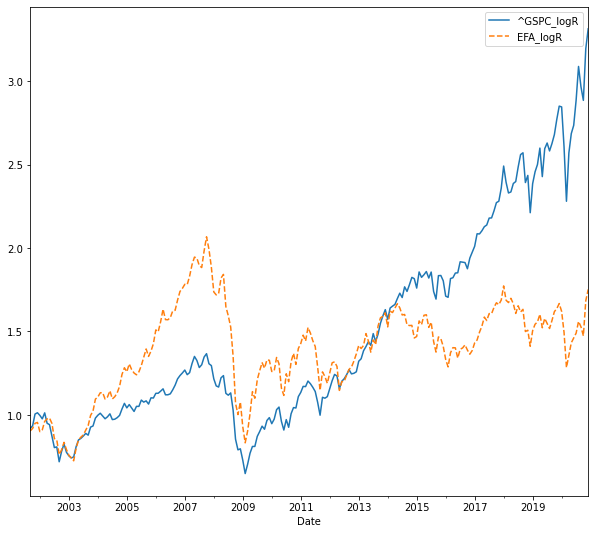

In [39]:
#cal_ret for Cross sectors
log_return_frame = cal_ret(subset)
#cal Retrun for index
log_index_frame = cal_ret_index(subset_index)
log_index_frame.dropna().cumsum().apply(np.exp).plot(figsize=(10,9),style=['-', '--','--','--'])

**Capture the Signal based on the 12 month average and 1 month average**
 -sum_

In [6]:
#subset.tail(50)
column = list(log_return_frame.columns)
def cal_w(frame):
    w_frame = frame
    for tick in cross_sector:
        log_return = tick+"_logR"
        slow_return = tick+"_Avg12"
        fast_return = tick+"_Avg1"
        slow_signal = tick+"_SlowSign"
        fast_signal = tick+"_FastSign"
        starS_return = tick+"_SlowReturn"
        starF_return = tick+"_FastReturn"
        w_frame[slow_return] = w_frame[log_return].rolling(12).mean()
        w_frame[fast_return] = w_frame[log_return].rolling(1).mean()
        w_frame[slow_signal] = np.sign(w_frame[slow_return])
        w_frame[fast_signal] = np.sign(w_frame[fast_return])
        w_frame[starS_return] = w_frame[slow_signal] * w_frame[slow_return].shift(1)
        w_frame[starF_return] = w_frame[fast_signal] * w_frame[fast_return].shift(1)
    w_frame = w_frame.dropna()
    w_frame = w_frame.drop(columns=column)
    #print(list(ret_frame.columns))
    return(w_frame)

In [7]:
#subset.tail(50)
index_column = list(log_index_frame.columns)
def cal_w_sp500(frame):
    w_frame = frame
    for tick in index:
        log_return = tick+"_logR"
        slow_return = tick+"_Avg12"
        fast_return = tick+"_Avg1"
        slow_signal = tick+"_SlowSign"
        fast_signal = tick+"_FastSign"
        starS_return = tick+"_SlowReturn"
        starF_return = tick+"_FastReturn"
        State = tick+"_State"
        w_frame[slow_return] = w_frame[log_return].rolling(12).mean()
        w_frame[fast_return] = w_frame[log_return].rolling(1).mean()
        w_frame[slow_signal] = np.sign(w_frame[slow_return])
        w_frame[fast_signal] = np.sign(w_frame[fast_return])
        w_frame[starS_return] = w_frame[slow_signal] * w_frame[slow_return].shift(1)
        w_frame[starF_return] = w_frame[fast_signal] * w_frame[fast_return].shift(1)
        w_frame[State] = np.where((w_frame[slow_signal] == 1) & (w_frame[fast_signal] == 1),'Bull',0)
        w_frame[State] = np.where((w_frame[slow_signal] == -1) & (w_frame[fast_signal] == -1),'Bear',w_frame[State] )
        w_frame[State] = np.where((w_frame[slow_signal] == 1) & (w_frame[fast_signal] == -1),'Correction',w_frame[State] )
        w_frame[State] = np.where((w_frame[slow_signal] == -1) & (w_frame[fast_signal] == 1),'Rebound',w_frame[State] )
    w_frame = w_frame.dropna()
    w_frame = w_frame.drop(columns=index_column)
    #print(list(ret_frame.columns))
    return(w_frame)

In [8]:
signal_frame = cal_w(log_return_frame)
signal_frame_index = cal_w_sp500(log_index_frame)
#signal_frame
# signal_frame.iloc[:1].mean()

In [9]:
def weight_return(row):
    return((row/len(cross_sector)))
# def sign_return(row):
#     return(np.sign(row))
def slow_strategy(frame):
    new='WeightSlow_'
    slow_frame = signal_frame.filter(regex=r"(_SlowReturn)")
    slow_frame_new = slow_frame.T.rank(method='dense')
    slow_frame_new = slow_frame_new.T
    slow_frame_new.rename(columns={i+'_SlowReturn':new+i for i in cross_sector},inplace=True)
    slow_frame_new =slow_frame_new.filter(regex='^Weight').apply(weight_return,axis=1)
    slow_sign = signal_frame.filter(regex='_SlowSign$')
    # slow_frame_new = slow_frame_new.filter(regex='_SlowReturn').apply(weight_return,axis=1)
    slow_frame_final = pd.concat([slow_frame,slow_frame_new,slow_sign],axis=1)
    return(slow_frame_final)
    return(cons)
def fast_strategy(frame):
    new='WeightFast_'
    fast_frame = signal_frame.filter(regex=r"(_FastReturn)")
    fast_frame_new = fast_frame.T.rank(method='dense')
    fast_frame_new = fast_frame_new.T
    fast_frame_new.rename(columns={i+'_FastReturn':new+i for i in cross_sector},inplace=True)
    fast_frame_new =fast_frame_new.filter(regex='^Weight').apply(weight_return,axis=1)
    fast_sign = signal_frame.filter(regex='_FastSign$')
    # slow_frame_new = slow_frame_new.filter(regex='_SlowReturn').apply(weight_return,axis=1)
    fast_frame_final = pd.concat([fast_frame,fast_frame_new,fast_sign],axis=1)
    return(fast_frame_final)
    #return(cons)
        
    

In [10]:
final_slow_df = slow_strategy(signal_frame)
final_fast_df = fast_strategy(signal_frame)

In [11]:
slow_column = list(final_slow_df.columns)
def startegy(frame):
    w_frame = frame
    for tick in cross_sector:
        weight_cl_S = "WeightSlow_"+tick
        slow_signal = tick+"_SlowSign"
        starS_return = tick+"_SlowReturn"
        dyn_return = tick+"_S_DynRet"
        #w_frame = w_frame.T
        #w_frame.assign(slow_re)
        w_frame[dyn_return] = w_frame.apply(lambda w_frame : w_frame[weight_cl_S]*w_frame[slow_signal]*w_frame[starS_return], axis = 1)
        #w_frame['Dyn_SlowRet'] = np.sum(w_frame[slow_signal] * w_frame[weight_cl_S] * w_frame[starS_return])
    w_frame = w_frame.dropna()
    w_frame = w_frame.drop(columns=slow_column)
    w_frame.loc[:,'Sum_S_Dyn'] = w_frame.sum(axis=1)
    #print(list(ret_frame.columns))
    return(w_frame)

In [12]:
fast_column = list(final_fast_df.columns)
def startegy_f(frame):
    w_frame = frame
    for tick in cross_sector:
        weight_cl_F = "WeightFast_"+tick
        fast_signal = tick+"_FastSign"
        starF_return = tick+"_FastReturn"
        dyn_return = tick+"_F_DynRet"
        #w_frame = w_frame.T
        #w_frame.assign(slow_re)
        w_frame[dyn_return] = w_frame.apply(lambda w_frame : w_frame[weight_cl_F]*w_frame[fast_signal]*w_frame[starF_return], axis = 1)
        #w_frame['Dyn_SlowRet'] = np.sum(w_frame[slow_signal] * w_frame[weight_cl_S] * w_frame[starS_return])
    w_frame = w_frame.dropna()
    w_frame = w_frame.drop(columns=fast_column)
    w_frame.loc[:,'Sum_F_Dyn'] = w_frame.sum(axis=1)
    #print(list(ret_frame.columns))
    return(w_frame)

In [13]:
x = startegy(final_slow_df)
y = startegy_f(final_fast_df)
signal_frame_index= signal_frame_index.filter(regex=r'^EFA')
z = pd.concat([x,y,signal_frame_index],axis=1)
#z = z.filter(regex='^Sum')
# x.loc[:,'Sum_S_Dyn'] = x.sum(axis=1)

In [22]:
z = z.dropna()

In [23]:
z.loc[(z['EFA_State'] == 'Correction') | (z['EFA_State'] == 'Rebound')]

,RPV_S_DynRet,RPG_S_DynRet,RYT_S_DynRet,Sum_S_Dyn,RPV_F_DynRet,RPG_F_DynRet,RYT_F_DynRet,Sum_F_Dyn,EFA_Avg12,EFA_Avg1,EFA_SlowSign,EFA_FastSign,EFA_SlowReturn,EFA_FastReturn,EFA_State
Date,,,,,,,,,,,,,,,
2007-12-01,-0.001224,0.004209,0.000050,0.003035,-0.042712,-0.026336,-0.032574,-0.101622,0.005803,-0.055501,1.0,-1.0,0.011309,0.036910,Correction
2008-03-01,-0.006007,-0.001146,-0.009289,-0.016442,-0.041272,-0.001620,-0.009237,-0.052129,-0.004950,0.004181,-1.0,1.0,0.002916,-0.010282,Rebound
2008-04-01,-0.019796,-0.001554,-0.007023,-0.028372,-0.038364,-0.008636,-0.011042,-0.058042,-0.003603,0.052954,-1.0,1.0,0.004950,0.004181,Rebound
2008-05-01,-0.019601,-0.001186,-0.005952,-0.026740,0.011236,0.038930,0.075333,0.125499,-0.004566,0.011802,-1.0,1.0,0.003603,0.052954,Rebound
2008-12-01,-0.073717,-0.015223,-0.036685,-0.125625,-0.095709,-0.101298,-0.105596,-0.302603,-0.046629,0.072326,-1.0,1.0,0.057282,-0.065841,Rebound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.005484,0.013377,0.028418,0.047279,0.006119,0.013492,0.026139,0.045750,0.006149,-0.028632,1.0,-1.0,0.013888,-0.018312,Correction
2020-04-01,-0.038038,-0.008034,-0.001798,-0.047869,-0.116421,-0.115652,-0.141745,-0.373818,-0.013802,0.056545,-1.0,1.0,0.016108,-0.152064,Rebound
2020-05-01,-0.031045,-0.000570,0.000742,-0.030873,0.044823,0.153466,0.092534,0.290823,-0.005095,0.052848,-1.0,1.0,0.013802,0.056545,Rebound


In [ ]:
# new='Rank_'
# slow_frame = signal_frame.filter(regex=r"(_SlowReturn)")
# slow_frame_new = slow_frame.T.rank(method='dense')
# slow_frame_new = slow_frame_new.T
# slow_frame_new.rename(columns={i+'_SlowReturn':new+i for i in cross_sector},inplace=True)
# slow_frame_new =slow_frame_new.filter(regex='^Rank').apply(weight_return,axis=1)
# slow_sign = signal_frame.filter(regex='_SlowSign$')
# # slow_frame_new = slow_frame_new.filter(regex='_SlowReturn').apply(weight_return,axis=1)
# slow_frame_final = pd.concat([slow_frame,slow_frame_new,slow_sign],axis=1)
# slow_frame_final


# #     #slow_frame.rename(columns={'RPV_Avg12':'Sign_RPV','RPG_Avg12':'Sign_RPG'},inplace=True)
# #     #slow_frame.dropc
# # slow_frame_final = pd.concat([slow_frame_new,slow_frame],axis=1)
# #     #slow_frame_final.assign(Weight= lambda slow_frame_final: slow_frame_final.iloc[,0] + slow_frame_final.iloc[,:1] )
# #     #x = slow_frame_final.filter(regex='^Sign').apply(sign_return,axis=1)
# # y = slow_frame_final.filter(regex='_Avg12$').apply(weight_return,axis=1)

# # cons = pd.concat([x,y],axis=1)

In [ ]:
# cons

In [ ]:
test = test.T.rank(method='dense')

In [ ]:
test = test.T

In [ ]:
test['Avg'] = test.mean(axis=1)

In [ ]:
test

In [ ]:
# for row in range(0,len(slow_frame)):
#     print(slow_frame.iloc[:row])
    #print ((rankw_frame(slow_frame.iloc[:row])).astype(int))

In [ ]:
(rankw_frame(slow_frame.iloc[:1])).astype(int)

In [ ]:
com = yf.Ticker(str('ARCT'))
inv = com.history(start='2000-01-01',end='2020-12-29')
inv['Close'].plot(figsize=(10,9))

In [ ]:
raw_EURUSD= EURUSD.history(period='24mo',interval='1mo')
raw_EURUSD

In [ ]:
w_frame = pd.w_frameFrame(raw_EURUSD)
w_frame.head(10)

In [ ]:
w_frame.drop(columns=['Open','High','Low','Volume','Dividends','Stock Splits'],inplace=True)
#w_frame.drop(columns=['Open','High','Low','Volume'],inplace=True)

In [ ]:
w_frame['log_r'] = np.log(w_frame['Close']/w_frame['Close'].shift(1))
w_frame['Slow'] = w_frame['log_r'].rolling(12).mean()
w_frame['Fast'] = w_frame['log_r'].rolling(1).mean()

In [ ]:
w_frame.dropna(inplace=True)
# w_frame.head(20)
speed = [0,(1/4),(1/2),(3/4),1]


In [ ]:
w_frame['Slow_Pos'] = np.where(w_frame['Slow'] >= 0,1,-1)
w_frame['Fast_Pos'] = np.where(w_frame['Fast'] >= 0,1,-1)
w_frame['Slow_ret'] = w_frame['Slow_Pos'] * w_frame['log_r'].shift(1)
w_frame['Fast_ret'] = w_frame['Fast_Pos'] * w_frame['log_r'].shift(1)

In [ ]:
w_frame.dropna(inplace=True)

w_frame[['Slow_ret','Fast_ret']].describe()

In [ ]:
w_frame['Inter_Short_Pos'] = np.where((w_frame['Slow_Pos'] > 0) & (w_frame['Fast_Pos'] < 0),((1-weight)*w_frame['Slow_Pos'])+(weight*w_frame['Fast_Pos']),0)
# w_frame.tail(24)

In [ ]:
w_frame['Inter_Short_Pos'] = np.where((w_frame['Slow_Pos'] < 0) & (w_frame['Fast_Pos'] > 0),((1-weight)*w_frame['Slow_Pos'])+(weight*w_frame['Fast_Pos']),w_frame['Inter_Short_Pos'])

In [ ]:
w_frame['State'] = np.where((w_frame['Slow_Pos'] == 1) & (w_frame['Fast_Pos'] == 1),'Bull',0)
w_frame['State'] = np.where((w_frame['Slow_Pos'] == -1) & (w_frame['Fast_Pos'] == -1),'Bear',w_frame['State'] )
w_frame['State'] = np.where((w_frame['Slow_Pos'] == 1) & (w_frame['Fast_Pos'] == -1),'Correction',w_frame['State'] )
w_frame['State'] = np.where((w_frame['Slow_Pos'] == -1) & (w_frame['Fast_Pos'] == 1),'Rebound',w_frame['State'] )

In [ ]:
w_frame.tail(24)

In [ ]:
count_state = w_frame['log_r'].groupby(w_frame['State'])
count_state.describe()

In [ ]:
count_state = w_frame['Fast_ret'].groupby(w_frame['State'])
count_state.describe()

In [ ]:
count_state = w_frame['Slow_ret'].groupby(w_frame['State'])
count_state.describe()

In [ ]:
#market_states = w_frame.groupby(['Date','State']).size()

In [ ]:
# market_states = market_states.unstack()
# ax = market_states.plot(figsize=(24,10))
zx = w_frame.plot(subplots=True,figsize=(24,10))

In [ ]:
w_frame['Slow_return'] = np.log(w_frame['Slow']/w_frame['Slow'].shift(1))

In [ ]:
w_frame['Fast_return'] = np.log(w_frame['Fast']/w_frame['Fast'].shift(1))

In [ ]:
#w_frame.plot(title='AAAL Analsysis',figsize=(25,9))
w_frame.tail(60)

In [ ]:
w_frame['Position'] = np.where(w_frame['SMA15'] > w_frame['SMA30'],1,-1 )
w_frame.dropna(inplace=True)

In [ ]:
w_frame['returns'] = np.log(w_frame['Close'] / w_frame['Close'].shift(1))

In [ ]:
w_frame['returns'].hist(bins=25,figsize=(10,9))

In [ ]:
#w_frame.tail(15)
w_frame['stratgey'] = w_frame['Position'].shift(1) * w_frame['returns']

In [ ]:
w_frame[['stratgey','returns']].cumsum().apply(np.exp).plot(figsize=(10,9))

In [ ]:
w_frame[['stratgey','returns']].sum().apply(np.exp)

In [ ]:
w_frame[['stratgey','returns']].mean()*252*100